# QWOP AI

Direct screen capture for observation. Make sure QWOP is in Chrome and window is resized just before scroll bars appear. Place window in top-left of screen. Note that this project is intended to be run *locally* on a computer where you can easily set up the game window for screen capture.

Based on the "Build a Chrome Dino Game AI Model with Python" video by Nicholas Renotte: https://www.youtube.com/watch?v=vahwuupy81A

## Install dependencies

### Prerequisites

You will need to install OpenCV. The easiest way to do this is from the Anaconda environment. The newest version might work, but 4.7.0 worked for this notebook. You will also need [tesserocr](https://pypi.org/project/tesserocr/) for doing optical character recognition (OCR). Version 2.5.2 was verified working for this notebook.

```
conda install -c conda-forge opencv=4.7.0 tesserocr=2.5.2
```

Finally, you will need to install PyTorch for Stable Baselines3 to work. It is highly recommended that you use the GPU-enabled version of PyTorch for faster training. Follow the directions here: https://pytorch.org/get-started/locally/. This notebook was tested with the following:
 * PyTorch v2.0.0
 * OS: Windows
 * Package: Conda
 * Language: Python
 * Compute platform: CUDA 11.7

### Install packages

Uncomment the following cells to install the required packages. Note the versions on some of them. Gymnasium and Stable-Baselines3 change constantly, so I tried to version-lock these packages, as these are known to work with this notebook. Starting with v2.0.0, Stable-Baselines3 will only support gymnasium (and drop gym support). See [here](https://github.com/DLR-RM/stable-baselines3/releases/tag/v1.8.0) for more information.

In [1]:
# !python -m pip install mss pynput 
# !python -m pip install gymnasium==0.28.1
# !python -m pip install stable-baselines3[extra]==2.0.0a1
# !python -m pip install wandb

## Configuration

In [2]:
### Import libraries

# Screen capture
from mss import mss

# Sending commands (e.g. mouse/keyboard)
import pynput

# OpenCV for image manipulation
import cv2

# Optical character recognition (OCR)
import tesserocr
from PIL import Image

# Farama Foundation Gymnasium (fork of OpenAI gym)
import gymnasium as gym

# Reinforcement model modules
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import KVWriter, Logger
from stable_baselines3 import PPO

# Weights & Biases for remote logging
import wandb

# Other
import time
import datetime
import os
import numpy as np
from matplotlib import pyplot as plt
from typing import Any, Dict, Tuple, Union

In [94]:
### Settings

# Game observation
GAME_CROP = {
    'top':430, 
    'left':300, 
    'width':480, 
    'height':320
}

# Image resize (minimum of 36x36 for default CnnPolicies)
GAME_RESIZE_WIDTH = 36
GAME_RESIZE_HEIGHT = 36

# How big to make display image (0 for no display)
DISP_SCALE_FACTOR = 8.0

# Where to find the head/hair in the scaled game image
HEAD_ROW_MIN = 2
HEAD_ROW_MAX = 25
HEAD_PIXEL_THRESHOLD = 34
HEAD_HEIGHT_THRESHOLD = 9

# Score observation
SCORE_CROP = {
    'top':395, 
    'left':342, 
    'width':380, 
    'height':42
}
SCORE_RESIZE_WIDTH = 250
SCORE_RESIZE_HEIGHT = 40

# Game over screen
DONE_CROP = {
    'top':637, 
    'left':430, 
    'width':100, 
    'height':30}
DONE_RESIZE_WIDTH = 150
DONE_RESIZE_HEIGHT = 40
GAME_OVER_STRINGS = ["press"]

# Action settings
RESTART_MOUSE_POS = (300, 600)
RESTART_KEY = 'r'
ACTIONS_KEY_PRESS_TIME = 0.05
ACTIONS_MAP = {
    0: 'no-op',
    1: 'press q',
    2: 'press w',
    3: 'press o',
    4: 'press p',
    5: 'release q',
    6: 'release w',
    7: 'release o',
    8: 'release p'
}

# Reward settings
FALL_REWARD = -100
KNEEL_REWARD = -1
SCORE_MULTIPLIER = 10

# CnnPolicy requires 8-bit unsigned integers for images
DTYPE = np.uint8

# Size of sliding window average to calculate FPS
FPS_AVG_LEN = 30

# Checkpoint config
CHECKPOINT_DIR = "checkpoints"
CHECKPOINT_FREQ = 50_000 # 100k steps with 30 fps is about 30 min

# Log config
LOG_DIR = "logs"
LOG_FREQ = 10_000 # 10k steps with 30 fps is about 5 min

# Weights & Biases configuratino
WANDB_PROJECT = "qwop"

## Test Screen Capture

The following cells are used to test capturing screens and performing OCR. Such actions will be incorporated into the custom gymnasium Environment (Env) wrapper.

In [4]:
### Create screen capture object
screen = mss()

Shape: (1, 36, 36)
Example row: [162 171 162  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86
  86  86  86  86  86  86  86  86  86  86  86  86  86  86  86 159  22 166]


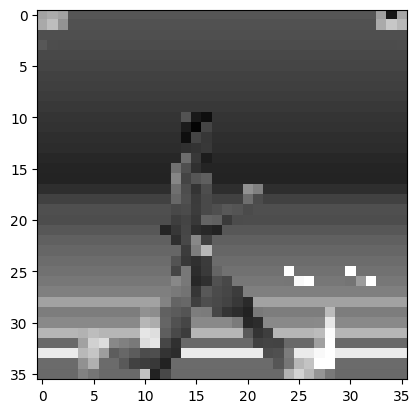

In [6]:
### Do screen grab and preprocess (make sure runner and some distance ahead is visible)

# Get screen grab and drop alpha channel
game_img = screen.grab(GAME_CROP)
game_img = np.array(game_img)[:, :, :3]

# Convert to grayscale and resize
game_img = cv2.cvtColor(game_img, cv2.COLOR_BGR2GRAY)
game_img = cv2.resize(game_img, (GAME_RESIZE_WIDTH, GAME_RESIZE_HEIGHT))

# Add channel dimension first (in case you want RGB later)
game_img = np.reshape(game_img, (1, GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH))

# Show crop/resized
print(f"Shape: {game_img.shape}")
print(f"Example row: {game_img[0, 0, :]}")
plt.imshow(game_img[0], cmap='gray', vmin=0, vmax=255)

# Try showing image in new window
if DISP_SCALE_FACTOR > 0:
    disp_width = int(GAME_RESIZE_WIDTH * DISP_SCALE_FACTOR)
    disp_height = int(GAME_RESIZE_HEIGHT * DISP_SCALE_FACTOR)
    disp_img = cv2.resize(game_img[0], (disp_width, disp_height), interpolation=cv2.INTER_AREA)
    cv2.namedWindow('Game Image')
    cv2.imshow('Game Image', disp_img)
    cv2.waitKey(2000)
    cv2.destroyAllWindows()

In [7]:
### Use scaled game image to find head height

# Print a few rows to see values
# print(game_img[0, HEAD_ROW_MIN:HEAD_ROW_MAX, :])

# Find dark pixels between two rows where the head likely is
locs = np.where(game_img[0, HEAD_ROW_MIN:HEAD_ROW_MAX, :] < HEAD_PIXEL_THRESHOLD)
rows = np.sort(locs[0]) + HEAD_ROW_MIN
print(f"Pixels below color threshold: " 
          f"{locs}")
print(f"Rows must be offset: {locs[0] + HEAD_ROW_MIN}")

# Give row of first dark pixel in likely head range
if rows.size > 0:
    print(f"Head at row {rows[0]}")
else:
    print(f"No head detected")

Pixels below color threshold: (array([ 8,  8,  9,  9, 10, 12], dtype=int64), array([15, 16, 14, 15, 14, 16], dtype=int64))
Rows must be offset: [10 10 11 11 12 14]
Head at row 10


In [8]:
### Create OCR context
timestamp = time.time()
ocr_api = tesserocr.PyTessBaseAPI()
print(f"Context setup: {(time.time() - timestamp):.5f} sec")

Context setup: 0.02898 sec


Screen grab: 0.00350 sec
Prep image: 0.00050 sec
OCR: 0.00400 sec
Total: 0.00801 sec
OCR string: -0.9 metres

Score: -0.9


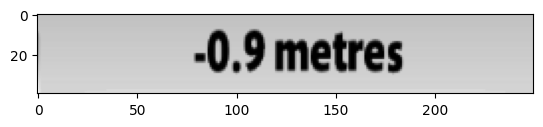

In [14]:
### Use OCR to get score

total_time = 0.0

# Get screen grab and drop alpha channel
timestamp = time.time()
score_img = screen.grab(SCORE_CROP)
score_img = np.array(score_img)[:, :, :3]
section_time = time.time() - timestamp
total_time += section_time
print(f"Screen grab: {section_time:.5f} sec")

# Smaller, grayscale image with dark text on light background makes for fast OCR
timestamp = time.time()
score_img = cv2.cvtColor(score_img, cv2.COLOR_BGR2GRAY)
score_img = cv2.resize(score_img, (SCORE_RESIZE_WIDTH, SCORE_RESIZE_HEIGHT))
score_img = 255 - score_img
pil_img = Image.fromarray(score_img)
section_time = time.time() - timestamp
total_time += section_time
print(f"Prep image: {section_time:.5f} sec")

# Use tesserocr to get text from image
ocr_str = ""
timestamp = time.time()
try:
    ocr_api.SetImage(pil_img)
    ocr_str = ocr_api.GetUTF8Text()
except:
    print("ERROR: Could not perform OCR")
    
# Display timing
section_time = time.time() - timestamp
total_time += section_time
print(f"OCR: {section_time:.5f} sec")
print(f"Total: {total_time:.5f} sec")

# Display OCR results
score = 0.0
if ocr_str:
    score_str = ocr_str.split()[0]
    try:
        score = float(float(score_str))
    except ValueError:
        pass
print(f"OCR string: {ocr_str}")
print(f"Score: {score}")

# Show image
plt.imshow(score_img, cmap='gray')

Screen grab: 0.00275 sec
Prep image: 0.00000 sec
OCR: 0.00351 sec
Total: 0.00627 sec
OCR string: press spa
Done: True


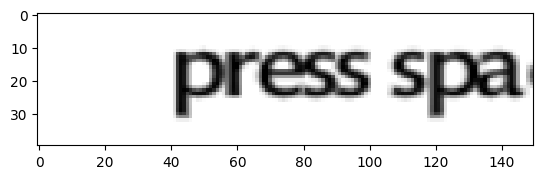

In [15]:
### Use OCR to get done screen

total_time = 0.0

# Get screen grab and drop alpha channel
timestamp = time.time()
done_img = screen.grab(DONE_CROP)
done_img = np.array(done_img)[:, :, :3]
section_time = time.time() - timestamp
total_time += section_time
print(f"Screen grab: {section_time:.5f} sec")

# Smaller, grayscale image with dark text on light background makes for fast OCR
timestamp = time.time()
done_img = cv2.cvtColor(done_img, cv2.COLOR_BGR2GRAY)
done_img = cv2.resize(done_img, (DONE_RESIZE_WIDTH, DONE_RESIZE_HEIGHT))
pil_img = Image.fromarray(done_img)
section_time = time.time() - timestamp
total_time += section_time
print(f"Prep image: {section_time:.5f} sec")

# Use tesserocr to get text from image
ocr_str = ""
timestamp = time.time()
try:
    ocr_api.SetImage(pil_img)
    ocr_str = ocr_api.GetUTF8Text()
except:
    print("ERROR: Could not perform OCR")
    
# Display timing
section_time = time.time() - timestamp
total_time += section_time
print(f"OCR: {section_time:.5f} sec")
print(f"Total: {total_time:.5f} sec")

# Display OCR results
done = False
ocr_str = ocr_str.strip()
if ocr_str:
    done_str = ocr_str.split()[0].lower()
    if done_str in GAME_OVER_STRINGS:
        done = True
print(f"OCR string: {ocr_str}")
print(f"Done: {done}")

# Show image
plt.imshow(done_img, cmap='gray')

In [16]:
### End OCR context
ocr_api.End()

## Test Spaces

The gymnasium Environment (Env) requires us to define the observation space and action space so it can know what kinds of data to expect when it interacts with the environment. For us, the observation space is the shape and bit width of the normalized, scaled screen capture (our runner and some space in front of them). The action space is all the available actions we can input into the game (q, w, o, p) along with doing nothing (no-op). We should also test the ability to restart the game (pressing space bar). As with the screen capture actions, these actions will be incorporated into the custom Env.

In [17]:
### Test observation space

# Create an observation space
observation_space = gym.spaces.Box(low=0,
                                   high=255,
                                   shape=(1, GAME_RESIZE_WIDTH, GAME_RESIZE_WIDTH),
                                   dtype=DTYPE)

# Randomly sample from it to show that it matches our expected input screen capture
obs = observation_space.sample()
print(f"Shape: {obs.shape}")
print(f"Example row: {obs[0, 0, :]}")

Shape: (1, 36, 36)
Example row: [ 35  68 183  66   6  93 132  27 121 116 134 125  43 234  33  71  68  81
  19 197   8 226 234 119 137  41 214 222 247  51 197   9  67   4  13  28]


In [18]:
### Test action space

# Create an action space
action_space = gym.spaces.Discrete(len(ACTIONS_MAP))

# Sample from it to show that we can randomly generate a number corresponding to an action
action = action_space.sample()
print(f"{action}: {ACTIONS_MAP[action]}")

1: press q


In [19]:
### Test control interaction: reset game and do some random stuff

# Create interaction objects
keyboard = pynput.keyboard.Controller()
mouse = pynput.mouse.Controller()

# Move mouse to QWOP window and click to bring to focus
mouse.position = RESTART_MOUSE_POS
mouse.press(pynput.mouse.Button.left)
mouse.release(pynput.mouse.Button.left)

# Press 'r' to restart game
keyboard.press(RESTART_KEY)
keyboard.release(RESTART_KEY)

# Sample randomly from our action space to control the game
for _ in range(10):
    action = action_space.sample()
    if ACTIONS_MAP[action] == 'press q':
        keyboard.press('q')
    elif ACTIONS_MAP[action] == 'press w':
        keyboard.press('w')
    elif ACTIONS_MAP[action] == 'press o':
        keyboard.press('o')
    elif ACTIONS_MAP[action] == 'press p':
        keyboard.press('p')
    elif ACTIONS_MAP[action] == 'release q':
        keyboard.release('q')
    elif ACTIONS_MAP[action] == 'release w':
        keyboard.release('w')
    elif ACTIONS_MAP[action] == 'release o':
        keyboard.release('o')
    elif ACTIONS_MAP[action] == 'release p':
        keyboard.release('p')
    print(f"{ACTIONS_MAP[action]}: {action}")
    time.sleep(ACTIONS_KEY_PRESS_TIME)
    
# Release everything
keyboard.release('q')
keyboard.release('w')
keyboard.release('o')
keyboard.release('p')

press p: 4
press w: 2
press p: 4
release o: 7
press q: 1
release q: 5
press p: 4
press w: 2
no-op: 0
no-op: 0


## Build gym Environment

Subclass gymnasium.Env to create a custom environment. Learn more here: https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/

In [99]:
class WebGame(gym.Env):
    """
    Subclass gymnasium Env class
    
    This is the gym wrapper class that allows our agent to interact with our environment. We need
    to implement four main methods: step(), reset(), render(), and close(). We should also define
    the action_space and observation space as class members.
    
    More information: https://gymnasium.farama.org/api/env/
    """
    
    # Set up the environment, action, and observation shapes. Optional timeout in seconds.
    def __init__(self, timeout=0.0, disp_scale=0.0, show_fps=False, debug_time=False):
        
        # Call superclass's constructor
        super().__init__()
        
        # Env requires us to define the action space
        self.action_space = gym.spaces.Discrete(len(ACTIONS_MAP))
        
        # Env requires us to define the observation space
        self.observation_space = gym.spaces.Box(low=0,
                                                high=255,
                                                shape=(1, GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH),
                                                dtype=DTYPE)
        
        # Screen capture object
        self.screen = mss()
        
        # OCR context
        self.ocr_api = tesserocr.PyTessBaseAPI()
        
        # Interaction objects
        self.keyboard = pynput.keyboard.Controller()
        self.mouse = pynput.mouse.Controller()
        
        # Record total score between rounds (to calculate reward each step)
        self.score = 0.0
        
        # Used to record the time
        self.timeout = timeout
        self.start_time = 0.0
        if self.timeout > 0.0:
            self.start_time = time.time()
            
        # How much to scale the render window
        self.disp_scale = disp_scale
        
        # Record time for debugging and showing FPS in render window
        self.fps = 0.0
        self.avg_fps_array = [0.0] * FPS_AVG_LEN
        self.show_fps = show_fps
        self.timestamp = time.time()
        self.debug_time = debug_time
        self.debug_start_time = time.time()
        self.debug_timestamp = time.time()

        # Initialize game image
        self.game_img = np.zeros((1, GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH))
        
        # Show rendering in new window if requested
        if self.disp_scale > 0.0:
            cv2.namedWindow('Game Image')
        
        pass
    
    # What happens when you take a step in the game (e.g. each frame)
    def step(self, action):
        
        # Debug timing
        self._show_debug_time("Step start")
        
        # Perform action (don't do anything for no-op)
        if ACTIONS_MAP[action] == 'press q':
            self.keyboard.press('q')
        elif ACTIONS_MAP[action] == 'press w':
            self.keyboard.press('w')
        elif ACTIONS_MAP[action] == 'press o':
            self.keyboard.press('o')
        elif ACTIONS_MAP[action] == 'press p':
            self.keyboard.press('p')
        elif ACTIONS_MAP[action] == 'release q':
            self.keyboard.release('q')
        elif ACTIONS_MAP[action] == 'release w':
            self.keyboard.release('w')
        elif ACTIONS_MAP[action] == 'release o':
            self.keyboard.release('o')
        elif ACTIONS_MAP[action] == 'release p':
            self.keyboard.release('p')
        self._show_debug_time("Perform action")
            
        # Get next observation and render
        obs = self.get_observation()
        self._show_debug_time("Get obs")
        
        # Use distance as total score. Calculate score difference between this step and previous.
        prev_score = self.score
        self.score = self.get_score()
        reward = self.score - prev_score
        reward *= SCORE_MULTIPLIER
        self._show_debug_time("Get score")
        
        # Check if done
        terminated = self.get_done()
        self._show_debug_time("Get done")
        
        # Penalize agent for letting head drop below a given row to discourage "scooting"
        head_row = self.get_head_row()
        if head_row > HEAD_HEIGHT_THRESHOLD:
            reward += KNEEL_REWARD
        self._show_debug_time("Get head row")
        
        # Penalize agent for falling
        if terminated:
            reward += FALL_REWARD
        
        # Check if we've exceeded the time limit
        elapsed_time = 0.0
        truncated = False
        if not terminated and self.timeout > 0.0:
            elapsed_time = time.time() - self.start_time
            if elapsed_time >= self.timeout:
                truncated = True
                
        # Release all control keys if ending
        if terminated or truncated:
            self.keyboard.release('q')
            self.keyboard.release('w')
            self.keyboard.release('o')
            self.keyboard.release('p')
            
        # Calculate FPS and slide average FPS window
        now = time.time()
        self.fps = 1 / (now - self.timestamp)
        self.avg_fps_array = self.avg_fps_array[1:]
        self.avg_fps_array.append(self.fps)
        self.timestamp = now
        
        # Return auxiliary information for debugging
        info = {'score': self.score, 'time': elapsed_time, 'fps': self.fps}
        
        # Done debugging time
        self._show_debug_time("Final checks")
        if self.debug_time:
            print("---")

        return obs, reward, terminated, truncated, info
    
    # Visualize the game using OpenCV
    def render(self, track_head=False):
        if self.disp_scale > 0:
            
            # Get the game image we plan to display
            disp_img = self.game_img[0]
            
            # Draw tracking marker for head and threshold row
            if track_head:
                head_row = self.get_head_row()
                head_col = int(disp_img.shape[1] / 2)
                disp_img[head_row, head_col] = 255
                disp_img[HEAD_HEIGHT_THRESHOLD, ::3] = 255
            
            # Resize our game image to something that can be easily seen
            disp_width = int(GAME_RESIZE_WIDTH * DISP_SCALE_FACTOR)
            disp_height = int(GAME_RESIZE_HEIGHT * DISP_SCALE_FACTOR)
            disp_img = cv2.resize(disp_img, (disp_width, disp_height), interpolation=cv2.INTER_AREA)
            
            # Add FPS counter to image
            if self.show_fps:
                fps = self.get_avg_fps()
                disp_img = cv2.putText(disp_img, 
                                       f"fps: {fps:.1f}", 
                                       (10, 25), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 
                                       1, 
                                       (255), 
                                       2, 
                                       cv2.LINE_AA)
                

                
            # Draw and wait 1 ms
            cv2.imshow('Game Image', disp_img)
            cv2.waitKey(1)
    
    # Restart the game
    def reset(self):
        
        # Wait, move mouse to game window, click for focus
        time.sleep(0.5)
        self.mouse.position = RESTART_MOUSE_POS
        self.mouse.press(pynput.mouse.Button.left)
        self.mouse.release(pynput.mouse.Button.left)
        
        # Press 'r' to restart game
        self.keyboard.press(RESTART_KEY)
        time.sleep(ACTIONS_KEY_PRESS_TIME)
        self.keyboard.release(RESTART_KEY)
        
        # Reset score and time
        self.score = 0.0
        if self.timeout > 0.0:
            self.start_time = time.time()
        
        # Let the game restart before getting the first observation
        time.sleep(0.3)
        
        # Get first observation of new game
        obs = self.get_observation()
        
        # Return auxiliary information for debugging
        info = {'score': self.score, 'time': 0.0, 'fps': 0.0}
        
        return obs, info
    
    # Close down the game: release keys, close OpenCV windows, end OCR context
    def close(self):
        self.keyboard.release('q')
        self.keyboard.release('w')
        self.keyboard.release('o')
        self.keyboard.release('p')
        cv2.destroyAllWindows()
        ocr_api.End()
    
    # Get the part of the observation of the game that we want (e.g. crop, resize)
    def get_observation(self):
        
        # Get screen grab and drop alpha channel
        game_img = screen.grab(GAME_CROP)
        game_img = np.array(game_img, dtype=DTYPE)[:, :, :3]

        # Convert to grayscale and resize
        game_img = cv2.cvtColor(game_img, cv2.COLOR_BGR2GRAY)
        game_img = cv2.resize(game_img, (GAME_RESIZE_WIDTH, GAME_RESIZE_HEIGHT))
        
        # Add channel dimension first (in case you want RGB later)
        game_img = np.reshape(game_img, (1, GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH))
        
        # Render
        self.game_img = game_img
        self.render(track_head=True)
        
        return game_img
    
    # Get the distance ran to use as a total score and to calculate rewards
    def get_score(self):
        
        # Get screen grab and drop alpha channel
        score_img = screen.grab(SCORE_CROP)
        score_img = np.array(score_img)[:, :, :3]

        # Resize, convert to grayscale, invert for fast OCR
        score_img = cv2.cvtColor(score_img, cv2.COLOR_BGR2GRAY)
        score_img = cv2.resize(score_img, (SCORE_RESIZE_WIDTH, SCORE_RESIZE_HEIGHT))
        score_img = 255 - score_img
        pil_img = Image.fromarray(score_img)

        # Do OCR
        ocr_str = ""
        try:
            self.ocr_api.SetImage(pil_img)
            ocr_str = self.ocr_api.GetUTF8Text()
        except:
            print("ERROR: Could not perform OCR")
        
        # Extract score as a number
        score = 0.0
        ocr_str = ocr_str.strip()
        if ocr_str:
            score_str = ocr_str.split()[0]
            try:
                score = float(float(score_str))
            except ValueError:
                pass
        
        return score
    
    # Get the row of the head
    def get_head_row(self):
        
        # Give row of first dark pixel in likely head range
        locs = np.where(self.game_img[0, HEAD_ROW_MIN:HEAD_ROW_MAX, :] < HEAD_PIXEL_THRESHOLD)
        rows = np.sort(locs[0]) + HEAD_ROW_MIN
        if rows.size > 0:
            return rows[0]
        else:
            return -1
    
    # Get the done text using OCR
    def get_done(self):
        
        # Get screen grab and drop alpha channel
        done_img = screen.grab(DONE_CROP)
        done_img = np.array(done_img)[:, :, :3]
        
        # Resize, convert to grayscale, invert for fast OCR
        done_img = cv2.cvtColor(done_img, cv2.COLOR_BGR2GRAY)
        done_img = cv2.resize(done_img, (SCORE_RESIZE_WIDTH, SCORE_RESIZE_HEIGHT))
        pil_img = Image.fromarray(done_img)
        
        # Do OCR
        ocr_str = ""
        try:
            self.ocr_api.SetImage(pil_img)
            ocr_str = self.ocr_api.GetUTF8Text()
        except:
            print("ERROR: Could not perform OCR")

        # Extract done state as a boolean
        done = False
        ocr_str = ocr_str.strip()
        if ocr_str:
            done_str = ocr_str.split()[0].lower()
            if done_str in GAME_OVER_STRINGS:
                done = True
                
        return done
    
    # Get average FPS
    def get_avg_fps(self):
        return sum(self.avg_fps_array) / len(self.avg_fps_array)
    
    # Report time elapsed from environment start and time elapsed from last call
    def _show_debug_time(self, msg=""):
        if self.debug_time:
            debug_now = time.time()
            print(f"Timestamp: {(debug_now - self.debug_start_time):.2f} | "
                  f"Since last: {(debug_now - self.debug_timestamp):.2f} | "
                  f"{msg}")
            self.debug_timestamp = debug_now

## Test gym Environment

It's always a good idea to test your environment wrapper before training.

In [100]:
# Create our environment with a timeout
try:
    env.close()
except NameError:
    pass
env = WebGame(timeout=5.0, 
              disp_scale=2.0, 
              show_fps=True, 
              debug_time=False)

Score: 1.1
Done: True
Shape: (1, 36, 36)


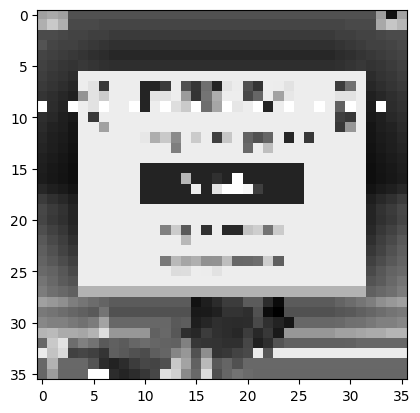

In [101]:
### Test environment wrapper methods

# Get current score
print(f"Score: {env.get_score()}")

# See if game is done
print(f"Done: {env.get_done()}")

# Get the current observation
obs = env.get_observation()
print(f"Shape: {obs.shape}")
plt.imshow(obs[0], cmap='gray')

In [102]:
### Test game loop

debug = False

# Do a few game loops
for ep in range(3):
    
    # Initialize game
    obs, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    
    # Do a single game loop
    while not terminated and not truncated:
        obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
        total_reward += reward
        if debug:
            print(f"Score: {info['score']}, Time: {info['time']}, FPS: {info['fps']}, "
                  f"Terminated: {terminated}, Truncated: {truncated}")
        
    # Show results
    avg_fps = env.get_avg_fps()
    print(f"Total reward for episode {ep} is {total_reward:.2f} | Average FPS: {avg_fps:.1f}")

Total reward for episode 0 is -144.00 | Average FPS: 31.8
Total reward for episode 1 is -73.00 | Average FPS: 32.4
Total reward for episode 2 is -21.00 | Average FPS: 32.7


In [61]:
# Test if game runs while lid is closed
# Should receive consistent ~ -1 m scores
num_tests = 5
for ep in range(num_tests):
    
    # Initialize game
    obs, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    action = 3
    
    # Do a single game loop
    while not terminated and not truncated:
        
        # Hold 'o' to fall forward
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if debug:
            print(f"Score: {info['score']}, Time: {info['time']}, "
                  f"Terminated: {terminated}, Truncated: {truncated}")
        
    # Show results
    avg_fps = env.get_avg_fps()
    print(f"Total reward for episode {ep} is {total_reward:.2f} | Average FPS: {avg_fps:.1f}")

Total reward for episode 0 is -125.40 | Average FPS: 30.7
Total reward for episode 1 is -124.40 | Average FPS: 29.3
Total reward for episode 2 is -124.40 | Average FPS: 31.2
Total reward for episode 3 is -125.40 | Average FPS: 33.4
Total reward for episode 4 is -131.30 | Average FPS: 33.4


In [89]:
# Final environment check to make sure it works with Stable-Baselines3
env_checker.check_env(env)

## Checkpoint callback

We'll create a custom callback for Stable Baselines3 that saves the model every n steps. This helps us recover from an error, disconnect, or power loss.

In [103]:
class SaveCheckpointCallback(BaseCallback):
    """
    Save the model every ``check_freq`` steps
    
    More information: https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html
    """
    
    # Constructor
    def __init__(self, check_freq, save_dir, verbose=1):
        super(SaveCheckpointCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_dir = save_dir
        
    # Create directory for saving the models
    def _init_callback(self):
        if self.save_dir is not None:
            os.makedirs(self.save_dir, exist_ok=True)
            
    # Save model every check_freq steps
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_dir, f"model_{self.n_calls}")
            self.model.save(model_path)
        return True

In [104]:
# Set up checkpoint callback
checkpoint_callback = SaveCheckpointCallback(
    check_freq=CHECKPOINT_FREQ, 
    save_dir=CHECKPOINT_DIR,
    verbose=1
)

## Custom logger

I'm going to use Weights & Biases for logging so I can view the training progress remotely. See the [Logger documentation](https://stable-baselines3.readthedocs.io/en/master/common/logger.html) and [integration examples](https://github.com/DLR-RM/stable-baselines3/blob/master/docs/guide/integrations.rst) for how to create a custom writer.

Feel free to use a different method for logging, such as TensorBoard. See [here](https://stable-baselines3.readthedocs.io/en/master/guide/tensorboard.html) for how to set up TensorBoard.

In [105]:
class WandBWriter(KVWriter):
    """
    Log metrics to Weights & Biases when called by .learn()
    
    More info: https://stable-baselines3.readthedocs.io/en/master/_modules/stable_baselines3/common/logger.html#KVWriter
    """
    
    # Initialize run
    def __init__(self, run, verbose=1):
        super().__init__()
        self.run = run
        self.verbose = verbose

    # Write metrics to W&B project
    def write(self, 
              key_values: Dict[str, Any], 
              key_excluded: Dict[str, Union[str, Tuple[str, ...]]], 
              step: int = 0) -> None:
        log_dict = {}
        
        # Go through each key/value pairs
        for (key, value), (_, excluded) in zip(
            sorted(key_values.items()), sorted(key_excluded.items())):
            
            if self.verbose >= 2:
                print(f"step={step} | {key} : {value} ({type(value)})")
            
            # Skip excluded items
            if excluded is not None and "wandb" in excluded:
                continue
                
            # Log integers and floats
            if isinstance(value, np.ScalarType):
                if not isinstance(value, str):
                    wandb.log(data={key: value}, step=step)
                    log_dict[key] = value
                
        # Print to console
        if self.verbose >= 1:
            print(f"Log for steps={step}")
            print(f"--------------")
            for (key, value) in sorted(log_dict.items()):
                print(f"  {key}: {value}")
            print()
                
    # Close the W&B run
    def close(self) -> None:
        self.run.finish()

In [106]:
# Log in to Weights & Biases
wandb.login()

True

In [107]:
# Create new W&B run
config = {}
dt = datetime.datetime.now(datetime.timezone.utc)
dt = dt.replace(microsecond=0, tzinfo=None)
run = wandb.init(project=WANDB_PROJECT, name=str(dt), config=config)

# Print run info
print(f"WandB run ID: {run.id}")
print(f"WandB run name: {run.name}") 

WandB run ID: s0x9gyn7
WandB run name: 2023-05-13 22:16:55


In [108]:
# Set custom logger with our custom writer
wandb_writer = WandBWriter(run, verbose=0)
loggers = Logger(
    folder=None,
    output_formats=[wandb_writer]
)

## Train Model

In [109]:
# Hyperparameters
hparams = {
    "episode_timeout": 300,             # 5 min episode timeout
    "learning_rate": 0.0001,            # Default is 0.0003
    "steps_per_update": 1024,           # Default is 2048
    "total_timesteps": 100_000,         # 100k steps at 30 fps is about 55 min
    "num_actions": len(ACTIONS_MAP),
    "model_name": "qwop_model_v04",
    "notes": "Fixed OCR. Now around 30 FPS."
}

# Log hyperparameters to W&B
wandb.config.update(hparams)

In [110]:
# Create our environment with a timeout for training
try:
    env.close()
except NameError:
    pass
env = WebGame(timeout=hparams["episode_timeout"], 
              disp_scale=DISP_SCALE_FACTOR, 
              show_fps=True)

In [111]:
# Create model
# More information: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html
model = PPO('CnnPolicy', 
            env, 
            verbose=0,
            learning_rate=hparams["learning_rate"], 
            n_steps=hparams["steps_per_update"])

In [112]:
# Choo choo train!
# total_timesteps: take at least this many steps, will st op on multiple of n_steps in PPO
# Host tensorboard on LAN: tensorboard --host 0.0.0.0 --logdir logs\PPO_n
# (But note that we're using Weights & Biases for remote logging instead)
# About logs: https://stable-baselines3.readthedocs.ioqqp/en/master/common/logger.html
# About plots: https://medium.com/aureliantactics/understanding-ppo-plots-in-tensorboard-cbc3199b9ba2
model.set_logger(loggers)
model.learn(total_timesteps=hparams["total_timesteps"], 
            callback=[checkpoint_callback])

In [83]:
# Exit environment and close W&B run
env.close()
run.finish()

In [ ]:
# Save final model
model.save(hparams["model_name"])

## Test model

In [113]:
# Create our environment for testing
try:
    env.close()
except NameError:
    pass
env = WebGame(timeout=30.0, disp_scale=DISP_SCALE_FACTOR, show_fps=True)

In [ ]:
# Load model (use final model or any checkpoint)
model = PPO.load(
    os.path.join(".", "qwop_model_v03"),
    # os.path.join(".", hparams["model_name"]), 
    env=env, 
    print_system_info=True
)

In [114]:
# Play game
for ep in range(3):
    
    # Reset game
    obs, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    step_count = 0
    
    # Perform actions based on observation and accumulate reward
    while not terminated and not truncated:
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(int(action))
        total_reward += reward
        step_count += 1
        
    # Print total reward at the end of the episode
    print(f"Episode {ep} | Steps: {step_count}, Total reward: {total_reward}")

Episode 0 | Steps: 622, Total reward: -144.0
Episode 1 | Steps: 859, Total reward: 0.9999999999999998


KeyboardInterrupt: 

In [ ]:
# We're done! Close the environment
env.close()

## TODO:

 * Make step faster (>10 fps)
   * Disable rendering?
   * Check by removing parts of step() (probably opencv or mss being slow)
   * Print FPS in wandb metrics
 * Reward forward motion
 * Frame stacking